## VI. Practical PyTorch Applications
Now that we have seen how to build and train a basic neural network, let's try our hand at something slightly more advanced. Let's see how we can train a Convolutional Neural Network (CNN) on an image dataset.

Train simpleNet on MNIST dadaset

In [21]:
from torch import nn
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
import torchvision

from torch.optim import Adam
from torch.utils.data import random_split
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset


In [3]:
# Download training and test MNSIT dataset
train_data = MNIST(root='data/', train=True, download=True, transform=ToTensor())
test_data = MNIST(root='data/', train=False, download=True, transform=ToTensor())

2.3%

100.0%


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100.0%
69.6%

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100.0%
100.0%


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [4]:
# Create training and test dataloaders
train_dataloader = DataLoader(train_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

Image batch dimensions: torch.Size([64, 1, 28, 28])
Image label dimensions: torch.Size([64])


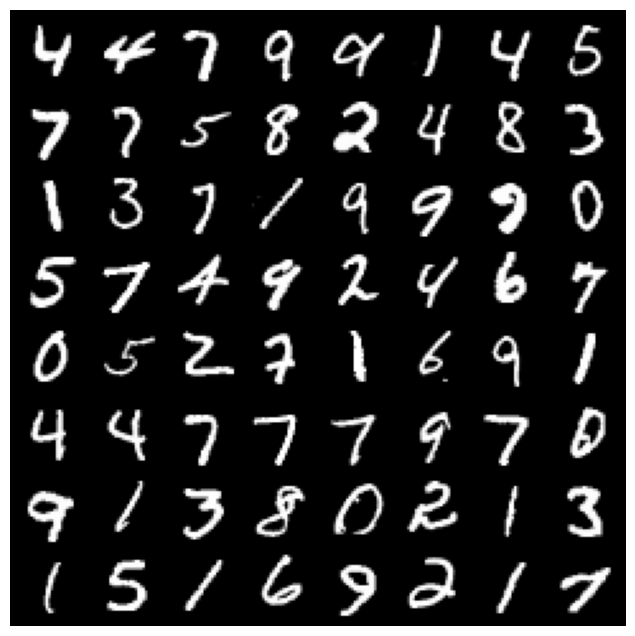

In [5]:

# Visualize a batch of training data
for images, labels in train_dataloader:
    print("Image batch dimensions:", images.shape)
    print("Image label dimensions:", labels.shape)
    plt.figure(figsize=(16, 8))
    plt.axis('off')
    plt.imshow(np.transpose(torchvision.utils.make_grid(images, padding=2, normalize=True), (1, 2, 0)))
    break

In [24]:
# Define a dense neural network
class simpleNet(nn.Module):
    def __init__(self):
        super(simpleNet, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, 10)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.softmax(self.fc3(x))
        return x

In [25]:
import time

# Train the model
model = simpleNet()
# check device of model
print(next(model.parameters()).device)

optimizer = Adam(model.parameters(), lr=0.01)
loss_fn = nn.CrossEntropyLoss()
epochs = 5
for epoch in range(epochs):
    start_time = time.time()
    for batch_idx, (data, target) in enumerate(train_dataloader):
        optimizer.zero_grad()
        output = model(data)
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 200 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(epoch,
                                                                           batch_idx * len(data),
                                                                           len(train_dataloader.dataset),
                                                                           100. * batch_idx / len(train_dataloader),
                                                                           loss.item()))
    print('Epoch {} took {} seconds'.format(epoch, time.time() - start_time))

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.302497
Train Epoch: 0 [12800/60000 (21%)]	Loss: 1.867186
Train Epoch: 0 [25600/60000 (43%)]	Loss: 2.070526
Train Epoch: 0 [38400/60000 (64%)]	Loss: 2.148651
Train Epoch: 0 [51200/60000 (85%)]	Loss: 2.164276
Epoch 0 took 5.146381855010986 seconds
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.179900
Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.195526
Train Epoch: 1 [25600/60000 (43%)]	Loss: 2.258026
Train Epoch: 1 [38400/60000 (64%)]	Loss: 2.383026
Train Epoch: 1 [51200/60000 (85%)]	Loss: 2.367401
Epoch 1 took 5.439297914505005 seconds
Train Epoch: 2 [0/60000 (0%)]	Loss: 2.351776
Train Epoch: 2 [12800/60000 (21%)]	Loss: 2.367401
Train Epoch: 2 [25600/60000 (43%)]	Loss: 2.367401
Train Epoch: 2 [38400/60000 (64%)]	Loss: 2.320526
Train Epoch: 2 [51200/60000 (85%)]	Loss: 2.461151
Epoch 2 took 5.380577087402344 seconds
Train Epoch: 3 [0/60000 (0%)]	Loss: 2.273651
Train Epoch: 3 [12800/60000 (21%)]	Loss: 2.351776
Train Epoch: 3 [25600/60000 (43%)]	Loss: 2.351776
Tra

In [26]:
# Test the model
model.eval()
test_loss = 0
correct = 0
with torch.no_grad():
    for data, target in test_dataloader:
        output = model(data)
        test_loss += loss_fn(output, target).item()
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).sum()
test_loss /= len(test_dataloader.dataset)
print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(test_loss,
                                                                           correct,
                                                                           len(test_dataloader.dataset),
                                                                           100. * correct / len(test_dataloader.dataset)))


Test set: Avg. loss: 0.0369, Accuracy: 1135/10000 (11%)



In [10]:
# use GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [27]:
# Train the model on GPU
model = simpleNet().to(device)
optimizer = Adam(model.parameters(), lr=0.01)
loss_func = nn.CrossEntropyLoss()
epochs = 10
for epoch in range(epochs):
    start_time = time.time()
    for batch_idx, (data, target) in enumerate(train_dataloader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 200 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(epoch,
                                                                           batch_idx * len(data),
                                                                           len(train_dataloader.dataset),
                                                                           100. * batch_idx / len(train_dataloader),
                                                                           loss.item()))
    print('Epoch {} took {} seconds'.format(epoch, time.time() - start_time))

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.303196
Train Epoch: 0 [12800/60000 (21%)]	Loss: 2.210593
Train Epoch: 0 [25600/60000 (43%)]	Loss: 2.163756
Train Epoch: 0 [38400/60000 (64%)]	Loss: 2.148651
Train Epoch: 0 [51200/60000 (85%)]	Loss: 2.336151
Epoch 0 took 3.576296329498291 seconds
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.351776
Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.320526
Train Epoch: 1 [25600/60000 (43%)]	Loss: 2.398651
Train Epoch: 1 [38400/60000 (64%)]	Loss: 2.211151
Train Epoch: 1 [51200/60000 (85%)]	Loss: 2.211151
Epoch 1 took 3.547208070755005 seconds
Train Epoch: 2 [0/60000 (0%)]	Loss: 2.304901
Train Epoch: 2 [12800/60000 (21%)]	Loss: 2.226776
Train Epoch: 2 [25600/60000 (43%)]	Loss: 2.195526
Train Epoch: 2 [38400/60000 (64%)]	Loss: 2.367401
Train Epoch: 2 [51200/60000 (85%)]	Loss: 2.351776
Epoch 2 took 3.5956175327301025 seconds
Train Epoch: 3 [0/60000 (0%)]	Loss: 2.398651
Train Epoch: 3 [12800/60000 (21%)]	Loss: 2.351776
Train Epoch: 3 [25600/60000 (43%)]	Loss: 2.383026
Tr

In [39]:
# Test the model on GPU
model.eval()
test_loss = 0
correct = 0
with torch.no_grad():
    for data, target in test_dataloader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        test_loss += loss_fn(output, target).item()
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).sum()
test_loss /= len(test_dataloader.dataset)
print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(test_loss,
                                                                           correct,
                                                                           len(test_dataloader.dataset),
                                                                           100. * correct / len(test_dataloader.dataset)))


Test set: Avg. loss: 0.0043, Accuracy: 9333/10000 (93%)



# Define a convolutional neural network

In [16]:
class simpleCNN(nn.Module):
    def __init__(self):
        super(simpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(-1, 64 * 7 * 7)
        x = self.relu(self.fc1(x))
        x = self.softmax(self.fc2(x))
        return x

In [22]:
# Train the model on GPU
model = simpleCNN().to(device)
optimizer = Adam(model.parameters(), lr=0.01)
loss_func = nn.CrossEntropyLoss()
epochs = 10
for epoch in range(epochs):
    start_time = time.time()
    for batch_idx, (data, target) in enumerate(train_dataloader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 200 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(epoch,
                                                                           batch_idx * len(data),
                                                                           len(train_dataloader.dataset),
                                                                           100. * batch_idx / len(train_dataloader),
                                                                           loss.item()))
    print('Epoch {} took {} seconds'.format(epoch, time.time() - start_time))

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.302859
Train Epoch: 0 [12800/60000 (21%)]	Loss: 1.545766
Train Epoch: 0 [25600/60000 (43%)]	Loss: 1.585957
Train Epoch: 0 [38400/60000 (64%)]	Loss: 1.508075
Train Epoch: 0 [51200/60000 (85%)]	Loss: 1.492839
Epoch 0 took 3.8308911323547363 seconds
Train Epoch: 1 [0/60000 (0%)]	Loss: 1.539276
Train Epoch: 1 [12800/60000 (21%)]	Loss: 1.570526
Train Epoch: 1 [25600/60000 (43%)]	Loss: 1.523651
Train Epoch: 1 [38400/60000 (64%)]	Loss: 1.554901
Train Epoch: 1 [51200/60000 (85%)]	Loss: 1.570892
Epoch 1 took 3.796741485595703 seconds
Train Epoch: 2 [0/60000 (0%)]	Loss: 1.508026
Train Epoch: 2 [12800/60000 (21%)]	Loss: 1.633969
Train Epoch: 2 [25600/60000 (43%)]	Loss: 1.570526
Train Epoch: 2 [38400/60000 (64%)]	Loss: 1.695526
Train Epoch: 2 [51200/60000 (85%)]	Loss: 1.664276
Epoch 2 took 3.76989483833313 seconds
Train Epoch: 3 [0/60000 (0%)]	Loss: 1.695213
Train Epoch: 3 [12800/60000 (21%)]	Loss: 1.554901
Train Epoch: 3 [25600/60000 (43%)]	Loss: 1.617401
Tra

### Transfer learning
In this section, we will use a pre-trained model to do transfer learning. We will use the ResNet-18 model, which is trained on the ImageNet dataset. We will use the model to classify the MNIST dataset.

In [32]:
from torchvision import models

# Load pre-trained ResNet18
model = models.resnet18(pretrained=True)
# Freeze the parameters of the convolutional layers
for param in model.parameters():
    param.requires_grad = False
model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False) # modify the first layer to accept single channel (grayscale) images
model.fc = nn.Linear(model.fc.in_features, 10) # MNIST has 10 classes



/home/liger/PycharmProjects/pytorch_tutorial/venv/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/liger/PycharmProjects/pytorch_tutorial/venv/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [41]:
from torch.optim.lr_scheduler import StepLR

# Train the model on GPU
model = model.to(device)
optimizer = Adam(model.parameters(), lr=0.001)
loss_func = nn.CrossEntropyLoss()
epochs = 10
scheduler = StepLR(optimizer, step_size=2, gamma=0.1) # learning rate is multiplied by gamma every step_size epochs

for epoch in range(epochs):
    start_time = time.time()
    scheduler.step()

    for batch_idx, (data, target) in enumerate(train_dataloader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 200 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(epoch,
                                                                           batch_idx * len(data),
                                                                           len(train_dataloader.dataset),
                                                                           100. * batch_idx / len(train_dataloader),
                                                                           loss.item()))
    print('Epoch {} took {} seconds'.format(epoch, time.time() - start_time))

Train Epoch: 0 [0/60000 (0%)]	Loss: 0.373800
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.140979
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.226789
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.224258
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.206694
Epoch 0 took 5.417624235153198 seconds
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.158744
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.024339
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.104293
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.031895
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.216967
Epoch 1 took 5.263399124145508 seconds
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.154643
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.248702
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.150426
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.180784
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.140205
Epoch 2 took 5.236211061477661 seconds
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.128722
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.374092
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.143214
Tra

### Learning rate scheduling

### Save and load the model

In [ ]:
torch.save(model.state_dict(), 'model.pt')
model.load_state_dict(torch.load('model.pt'))

### Data parallelism

In [ ]:
model = nn.DataParallel(model)

### References
- [PyTorch documentation](https://pytorch.org/docs/stable/index.html)
- [PyTorch tutorials](https://pytorch.org/tutorials/)